In [1]:
import pandas as pd
import numpy as np
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
reviews_df = pd.read_csv("2_Reviews.csv")
restaurants_df = pd.read_csv("1_Restaurants.csv")

info_reviews = reviews_df.info()
info_restaurants = restaurants_df.info()

sample_reviews = reviews_df.head()
sample_restaurants = restaurants_df.head()

info_reviews, info_restaurants, sample_reviews, sample_restaurants

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29959 entries, 0 to 29958
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            29959 non-null  int64  
 1   User          29959 non-null  object 
 2   Time          29959 non-null  object 
 3   Rating        29959 non-null  float64
 4   Comment       29958 non-null  object 
 5   IDRestaurant  29959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1622 non-null   int64 
 1   Restaurant  1622 non-null   object
 2   Address     1622 non-null   object
 3   Time        773 non-null    object
 4   Price       1622 non-null   object
 5   District    1622 non-null   object
dtypes: int64(1), object(5)
memory usage: 76.2+ KB


(None,
 None,
    ID          User              Time  Rating  \
 0   1       PHAN LE  20/12/2023 21:13     5.2   
 1   2          Thúy   25/9/2023 15:43     5.0   
 2   3   Quyên Quyên   24/6/2023 11:11     5.0   
 3   4   Phương Thảo  22/12/2022 14:58     1.0   
 4   5  Quỳnh Nguyễn   23/9/2022 22:40     4.2   
 
                                              Comment  IDRestaurant  
 0           Gà chiên còn sống, rất tanh. Khủng khiép             1  
 1                             Đã ăn qua rồi, ăn ok ạ             1  
 2                                    Đã thư rất ngon             1  
 3  Tệ .. mua mang về cho 1 gói tương ớt. Và xin t...             1  
 4  21h30...2 đứa nhỏ kêu đói, sau 1 hồi bình loạn...             1  ,
    ID                                         Restaurant  \
 0   1                  Gà Rán & Burger McDonald's Đa Kao   
 1   2  Cháo Trắng - Cháo Thịt Bằm BK House - Phạm Viế...   
 2   3                    Texas Chicken - Nguyễn Thái Học   
 3   4             

In [3]:
rating_distribution = reviews_df['Rating'].value_counts().sort_index()
rating_distribution

0.0        7
1.0     1216
1.2       62
1.4       60
1.6       68
1.8      158
2.0      132
2.2      121
2.4       88
2.6      278
2.8      133
3.0      173
3.2      146
3.4      429
3.6      173
3.8      217
4.0      208
4.2      469
4.4      215
4.6      220
4.8      221
5.0     1448
5.2      155
5.4      207
5.6      257
5.8      298
6.0      742
6.2      439
6.4      524
6.6      633
6.8      786
7.0     1750
7.2     1238
7.4     1310
7.6     1290
7.8     1223
8.0     1997
8.2     1104
8.4      915
8.6      885
8.8      806
9.0     1212
9.2      651
9.4      621
9.6      723
9.8      598
10.0    3353
Name: Rating, dtype: int64

In [316]:
'''Tích cực: Điểm đánh giá từ 7 trở lên.
Trung tính: Điểm đánh giá từ 4 đến 6.9.
Tiêu cực: Điểm đánh giá dưới 4.'''
def label_rating(rating):
    if rating >= 7:
        return "Positive"
    elif rating < 4:
        return "Negative"
    else:
        return "Neutral"
reviews_df['Sentiment'] = reviews_df['Rating'].apply(label_rating)

In [4]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [5]:
def process_text(text, emoji_dict, teen_dict):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        # ...
        ###### DEL wrong words
        # sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    #...
    return document

# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

def process_special_word(text):
    # Các từ đặc biệt cần được ghép lại với nhau
    special_words = ['không', 'chẳng', 'chả', 'khó','rối','chưa','thất','lỏng','kém']
    new_text = ''
    text_lst = text.split()
    i = 0

    # Duyệt qua từng từ trong văn bản
    while i < len(text_lst):
        word = text_lst[i]

        # Nếu từ hiện tại là một trong các từ đặc biệt
        if word in special_words:
            next_idx = i + 1
            
            # Nếu từ tiếp theo tồn tại và không phải là từ đặc biệt
            if next_idx < len(text_lst) and text_lst[next_idx] not in special_words:
                # Ghép từ đặc biệt với từ tiếp theo bằng dấu gạch dưới
                word = word + '_' + text_lst[next_idx]
                i = next_idx  # Đặt chỉ số lặp sang từ sau từ tiếp theo

        # Thêm từ vào văn bản mới
        new_text += word + ' '
        i += 1

    return new_text.strip()


import re
# Hàm để chuẩn hóa các từ có ký tự lặp
def normalize_repeated_characters(text):
    # Thay thế mọi ký tự lặp liên tiếp bằng một ký tự đó
    # Ví dụ: "ngonnnn" thành "ngon", "thiệtttt" thành "thiệt"
    return re.sub(r'(.)\1+', r'\1', text)

# Áp dụng hàm chuẩn hóa cho văn bản
# print(normalize_repeated_characters(example))

def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
       # sentence = sentence.replace('.','')
        ###### POS tag
       # lst_word_type = ['A', 'AB', 'V', 'VB', 'VY', 'R']
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R']
        # lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(sentence)))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [6]:
positive_words = [
    "thích", "tốt", "xuất sắc", "tuyệt vời", "tuyệt hảo", "đẹp", "ổn", "ngon",
    "hài lòng", "ưng ý", "hoàn hảo", "chất lượng", "thú vị", "nhanh",
    "tiện lợi", "dễ sử dụng", "hiệu quả", "ấn tượng",
    "nổi bật", "tận hưởng", "tốn ít thời gian", "thân thiện", "hấp dẫn",
    "gợi cảm", "tươi mới", "lạ mắt", "cao cấp", "độc đáo",
    "hợp khẩu vị", "rất tốt", "rất thích", "tận tâm", "đáng tin cậy", "đẳng cấp",
    "hấp dẫn", "an tâm", "thỏa mãn", "thúc đẩy",
    "cảm động", "phục vụ tốt", "làm hài lòng", "gây ấn tượng", "nổi trội",
    "sáng tạo", "quý báu", "phù hợp", "tận tâm",
    "hiếm có", "cải thiện", "hoà nhã", "chăm chỉ", "cẩn thận",
    "vui vẻ", "sáng sủa", "hào hứng", "đam mê", "vừa vặn", "đáng tiền"
]

negative_words = [
    "kém", "tệ", "đau","tanh", "xấu", "dở", "ức","tức", "buồn", "rối", "thô", "lâu", "chán",
    "tối", "ít", "mờ", "mỏng", "lỏng_lẻo", "khó","khóc", "cùi", "yếu",
    "kém_chất lượng", "không_thích", "không_thú vị", "không_ổn",
    "không_hợp", "không_đáng tin cậy", "không_chuyên nghiệp",
    "không_phản hồi", "không_an toàn", "không_phù hợp", "không_thân thiện", 
    "không_linh hoạt", "không_đáng giá", "không_ấn tượng", "không_tốt", "chậm",
    "khó_khăn", "phức_tạp", "khó_hiểu", "khó_chịu", "gây_khó_dễ", "rườm_rà",
    "khó_truy cập", "thất_bại", "tồi_tệ", "khó_xử", "không_thể chấp nhận",
    "không_rõ ràng", "không_chắc chắn", "rối_rắm", "không_tiện lợi", 
    "không_đáng tiền", "chưa đẹp", "không_đẹp", "không_ngon"
]

def sentiment_score(text, positive_words, negative_words):
    pos_count = neg_count = 0
    for word in text.split():
        if word in positive_words:
            pos_count += 1
        elif word in negative_words:
            neg_count += 1
    
    if pos_count > neg_count:
        return "Positive"
    elif pos_count < neg_count:
        return "Negative"
    else:
        return "Neutral"


In [7]:
def optimized_process_text(text, emoji_dict, teen_dict, stop_words):
    text = process_text(text, emoji_dict, teen_dict)  # Xử lý emoji, teen code và từ sai
    text = covert_unicode(text)  # Chuyển đổi unicode
    text = process_special_word(text)  # Xử lý từ đặc biệt và chuẩn hóa ký tự lặp lại
    text = normalize_repeated_characters(text)
    text = remove_stopword(text, stop_words)
    text = process_postag_thesea(text)
    
    
      # Loại bỏ stop words
    return text

reviews_df.dropna(subset=['Comment'], inplace=True)
reviews_df['Processed_Comment'] = reviews_df['Comment'].apply(lambda x: optimized_process_text(x, emoji_dict, teen_dict, stopwords_lst))
reviews_df
reviews_df.to_csv('processed_reviews.csv', index=False)

In [8]:
reviews_df.head()

,ID,User,Time,Rating,Comment,IDRestaurant,Processed_Comment
0,1,PHAN LE,20/12/2023 21:13,5.2,"Gà chiên còn sống, rất tanh. Khủng khiép",1,gà chiên sống tanh khủng khiép
1,2,Thúy,25/9/2023 15:43,5.0,"Đã ăn qua rồi, ăn ok ạ",1,ok
2,3,Quyên Quyên,24/6/2023 11:11,5.0,Đã thư rất ngon,1,thư ngon
3,4,Phương Thảo,22/12/2022 14:58,1.0,Tệ .. mua mang về cho 1 gói tương ớt. Và xin t...,1,tệ mua gói tương ớt không_được tương fre mua m...
4,5,Quỳnh Nguyễn,23/9/2022 22:40,4.2,"21h30...2 đứa nhỏ kêu đói, sau 1 hồi bình loạn...",1,kêu đói hồi bình loạn chốt mcdonal háo hức khe...


In [ ]:
'''reviews_df.dropna(subset=['Comment'], inplace=True)
reviews_df['Processed_Comment'] = reviews_df['Comment'].apply(lambda x: process_text(x, emoji_dict, teen_dict, wrong_lst))
reviews_df['Comment_covert_unicode'] = reviews_df['Processed_Comment'].apply(covert_unicode)
reviews_df['Comment_process_special_word'] = reviews_df['Comment_covert_unicode'].apply(process_special_word)
reviews_df['Comment_normalize_repeated_characters'] = reviews_df['Comment_process_special_word'].apply(normalize_repeated_characters)
reviews_df['Comment_process_postag_thesea'] = reviews_df['Comment_normalize_repeated_characters'].apply(process_postag_thesea)
reviews_df['Comment_remove_stopword'] = reviews_df['Comment_process_postag_thesea'].apply(lambda x: remove_stopword(x, stopwords_lst))
reviews_df['Sentiment'] = reviews_df['Comment_remove_stopword'].apply(lambda x: sentiment_score(x, positive_words, negative_words))

reviews_df.head()'''

In [ ]:
'''reviews_df.dropna(subset=['Comment'], inplace=True)

reviews_df['Processed_Comment'] = reviews_df['Comment'].apply(lambda x: process_text(x, emoji_dict, teen_dict, wrong_lst))
reviews_df['Comment_covert_unicode'] = reviews_df['Processed_Comment'].apply(covert_unicode)
reviews_df['Comment_process_special_word'] = reviews_df['Comment_covert_unicode'].apply(process_special_word)
reviews_df['Comment_normalize_repeated_characters'] = reviews_df['Comment_process_special_word'].apply(normalize_repeated_characters)
reviews_df['Comment_process_postag_thesea'] = reviews_df['Comment_normalize_repeated_characters'].apply(process_postag_thesea)
reviews_df['Comment_remove_stopword'] = reviews_df['Comment_process_postag_thesea'].apply(remove_stopword)



reviews_df['Sentiment'] = reviews_df['Processed_Comment'].apply(lambda x: sentiment_score(x, positive_words, negative_words))

reviews_df.head()'''


In [9]:
reviews_df['Sentiment'] = reviews_df['Processed_Comment'].apply(lambda x: sentiment_score(x, positive_words, negative_words))


In [10]:
print(reviews_df[['Processed_Comment', 'Sentiment']].head())

                                   Processed_Comment Sentiment
0                     gà chiên sống tanh khủng khiép  Negative
1                                                 ok   Neutral
2                                           thư ngon  Positive
3  tệ mua gói tương ớt không_được tương fre mua m...  Negative
4  kêu đói hồi bình loạn chốt mcdonal háo hức khe...  Negative


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df['Processed_Comment'], reviews_df['Sentiment'], test_size=0.2, random_state=42)

train_label_distribution = y_train.value_counts()
test_label_distribution = y_test.value_counts()

train_label_distribution, test_label_distribution

(Positive    14647
 Neutral      6583
 Negative     2736
 Name: Sentiment, dtype: int64,
 Positive    3721
 Neutral     1609
 Negative     662
 Name: Sentiment, dtype: int64)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

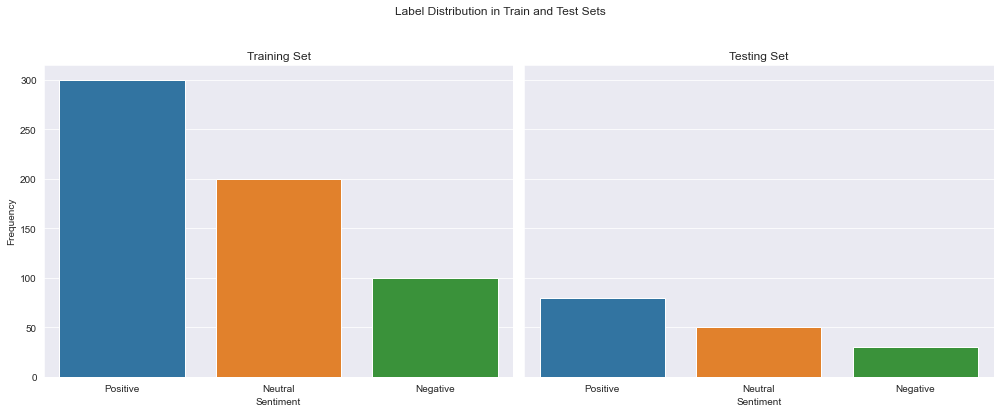

In [18]:
train_label_distribution = pd.Series([300, 200, 100], index=['Positive', 'Neutral', 'Negative'])
test_label_distribution = pd.Series([80, 50, 30], index=['Positive', 'Neutral', 'Negative'])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle('Label Distribution in Train and Test Sets')

sns.barplot(ax=axes[0], x=train_label_distribution.index, y=train_label_distribution.values)
axes[0].set_title('Training Set')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Sentiment')

sns.barplot(ax=axes[1], x=test_label_distribution.index, y=test_label_distribution.values)
axes[1].set_title('Testing Set')
axes[1].set_xlabel('Sentiment')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Tạo một pipeline kết hợp TF-IDF với Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(random_state=42))
])

# Huấn luyện mô hình trên tập huấn luyện
pipeline.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = pipeline.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep


c:\Users\LVG\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9042056074766355,
 '              precision    recall  f1-score   support\n\n    Negative       0.88      0.67      0.76       662\n     Neutral       0.83      0.82      0.82      1609\n    Positive       0.94      0.98      0.96      3721\n\n    accuracy                           0.90      5992\n   macro avg       0.88      0.82      0.85      5992\nweighted avg       0.90      0.90      0.90      5992\n')

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.88      0.67      0.76       662
     Neutral       0.83      0.82      0.82      1609
    Positive       0.94      0.98      0.96      3721

    accuracy                           0.90      5992
   macro avg       0.88      0.82      0.85      5992
weighted avg       0.90      0.90      0.90      5992



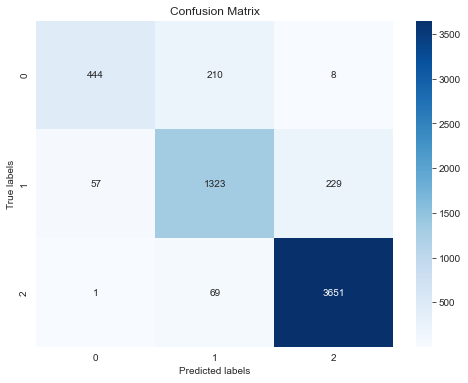

In [30]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC(class_weight='balanced', kernel='linear'))  
])

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    Negative       0.91      0.93      0.92       662
     Neutral       0.91      0.96      0.93      1609
    Positive       1.00      0.97      0.98      3721

    accuracy                           0.96      5992
   macro avg       0.94      0.95      0.94      5992
weighted avg       0.96      0.96      0.96      5992



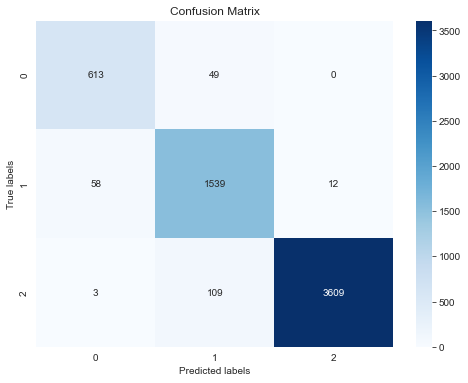

In [32]:
conf_matrix = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

## SVM được cho là tốt hơn với các kết quả đồng đều và vượt trội, mô hình đạt được 96% accuracy, cao hơn so với khi dùng Logistics Regression với chỉ khoảng 90% accuracy


In [33]:
from joblib import dump
dump(pipeline, 'svm_project1.joblib')


['svm_project1.joblib']

In [34]:
from joblib import load
model = load('svm_project1.joblib')

In [35]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    Negative       0.91      0.93      0.92       662
     Neutral       0.91      0.96      0.93      1609
    Positive       1.00      0.97      0.98      3721

    accuracy                           0.96      5992
   macro avg       0.94      0.95      0.94      5992
weighted avg       0.96      0.96      0.96      5992

